Url: https://tbrain.trendmicro.com.tw/Competitions/Details/2

In [1]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import col, udf, lag, rank, lit
from pyspark.sql.window import Window

In [2]:
global Path
if sc.master[0:5]=="local":
    #Path = "file:/c:/D Drive/work/bigData/pySpark/TBrain_Round2_DataSet_20180427"
    Path = "file:/Users/yungchuanlee/Documents/learn/AI競賽/ETF預測/TBrain_Round2_DataSet_20180427"
else:
    Path = "hdfs://master:9000/user/hduser"

In [3]:
float("    46.57")+float("     29,020".replace(",",""))

29066.57

In [4]:
#define alias of columns
col_alias_etf= {"代碼":"etf_id", "日期": "etf_date", "中文簡稱": "etf_name", "開盤價(元)":"etf_open", 
            "最高價(元)":"etf_high", "最低價(元)":"etf_low", "收盤價(元)":"etf_close", "成交張數(張)":"etf_count"}
col_alias_stock= {"代碼":"stock_id", "日期": "stock_date", "中文簡稱": "stock_name", "開盤價(元)":"stock_open", 
            "最高價(元)":"stock_high", "最低價(元)":"stock_low", "收盤價(元)":"stock_close", "成交張數(張)":"stock_count"}

In [5]:
#udf
def to_double(str_val):
    return float(str_val.replace(",",""))
to_double=udf(to_double)

In [6]:
#def function to read data (因檔案格式都相同)
def read_data(file_name, col_alias):
    str_cols = ["代碼","日期", "中文簡稱"]
    raw_data = spark.read.option("encoding", "Big5").csv(Path + "/" + file_name, header=True, sep=",")
    print("Total " + file_name + " count: " + str(raw_data.count()))
    #rename cols and correct type 
    num_cols = [col_name for col_name in raw_data.columns if col_name not in str_cols]
    final_data=raw_data.select( [col(str_col_name).alias(col_alias[str_col_name]) for str_col_name in str_cols] + 
                                  [to_double(col(num_col_name)).cast("double").alias(col_alias[num_col_name]) for num_col_name in num_cols] )
    final_data.printSchema()
    final_data.show(5)
    return final_data

In [7]:
print("starting import tetfp.csv(台灣18檔ETF股價資料)...")
tetfp_dt=read_data("tetfp.csv", col_alias_etf)

starting import tetfp.csv(台灣18檔ETF股價資料)...
Total tetfp.csv count: 19054
root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- etf_name: string (nullable = true)
 |-- etf_open: double (nullable = true)
 |-- etf_high: double (nullable = true)
 |-- etf_low: double (nullable = true)
 |-- etf_close: double (nullable = true)
 |-- etf_count: double (nullable = true)

+-------+--------+----------------+--------+--------+-------+---------+---------+
| etf_id|etf_date|        etf_name|etf_open|etf_high|etf_low|etf_close|etf_count|
+-------+--------+----------------+--------+--------+-------+---------+---------+
|0050   |20130102|元大台灣50          |    54.0|   54.65|   53.9|     54.4|  16487.0|
|0050   |20130103|元大台灣50          |    54.9|   55.05|  54.65|    54.85|  29020.0|
|0050   |20130104|元大台灣50          |   54.85|   54.85|   54.4|     54.5|   9837.0|
|0050   |20130107|元大台灣50          |   54.55|   54.55|   53.9|    54.25|   8910.0|
|0050   |20130108|元大台灣50     

In [8]:
#EDA
#range of date
tetfp_dt.describe('etf_date').show()

+-------+--------------------+
|summary|            etf_date|
+-------+--------------------+
|  count|               19054|
|   mean|2.0153294704733916E7|
| stddev|  15718.272009667517|
|    min|            20130102|
|    max|            20180427|
+-------+--------------------+



In [9]:
print("starting import taetfp.csv(台灣18檔ETF調整後股價資料)...")
taetfp_dt=read_data("taetfp.csv", col_alias_etf)

starting import taetfp.csv(台灣18檔ETF調整後股價資料)...
Total taetfp.csv count: 19053
root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- etf_name: string (nullable = true)
 |-- etf_open: double (nullable = true)
 |-- etf_high: double (nullable = true)
 |-- etf_low: double (nullable = true)
 |-- etf_close: double (nullable = true)
 |-- etf_count: double (nullable = true)

+-------+--------+----------------+--------+--------+-------+---------+---------+
| etf_id|etf_date|        etf_name|etf_open|etf_high|etf_low|etf_close|etf_count|
+-------+--------+----------------+--------+--------+-------+---------+---------+
|0050   |20130102|元大台灣50          |   46.57|   47.13|  46.49|    46.92|  16487.0|
|0050   |20130103|元大台灣50          |   47.35|   47.48|  47.13|    47.31|  29020.0|
|0050   |20130104|元大台灣50          |   47.31|   47.31|  46.92|     47.0|   9837.0|
|0050   |20130107|元大台灣50          |   47.05|   47.05|  46.49|    46.79|   8910.0|
|0050   |20130108|元大台灣50

In [10]:
print("starting import tsharep.csv(台灣個股股價資料)...")
tsharep_dt=read_data("tsharep.csv", col_alias_stock)

starting import tsharep.csv(台灣個股股價資料)...
Total tsharep.csv count: 2012609
root
 |-- stock_id: string (nullable = true)
 |-- stock_date: string (nullable = true)
 |-- stock_name: string (nullable = true)
 |-- stock_open: double (nullable = true)
 |-- stock_high: double (nullable = true)
 |-- stock_low: double (nullable = true)
 |-- stock_close: double (nullable = true)
 |-- stock_count: double (nullable = true)

+--------+----------+------------------+----------+----------+---------+-----------+-----------+
|stock_id|stock_date|        stock_name|stock_open|stock_high|stock_low|stock_close|stock_count|
+--------+----------+------------------+----------+----------+---------+-----------+-----------+
| 1101   |  20130102|台泥                |     38.95|      39.1|    38.65|       39.0|     6374.0|
| 1101   |  20130103|台泥                |      39.5|      39.5|    38.75|      38.85|     9710.0|
| 1101   |  20130104|台泥                |      39.4|     39.45|     38.6|       39.0|     8682.0|
| 1

In [11]:
print("starting import tasharep.csv(台灣個股調整後股價資料)...")
tasharep_dt=read_data("tasharep.csv", col_alias_stock)

starting import tasharep.csv(台灣個股調整後股價資料)...
Total tasharep.csv count: 2012609
root
 |-- stock_id: string (nullable = true)
 |-- stock_date: string (nullable = true)
 |-- stock_name: string (nullable = true)
 |-- stock_open: double (nullable = true)
 |-- stock_high: double (nullable = true)
 |-- stock_low: double (nullable = true)
 |-- stock_close: double (nullable = true)
 |-- stock_count: double (nullable = true)

+--------+----------+------------------+----------+----------+---------+-----------+-----------+
|stock_id|stock_date|        stock_name|stock_open|stock_high|stock_low|stock_close|stock_count|
+--------+----------+------------------+----------+----------+---------+-----------+-----------+
| 1101   |  20130102|台泥                |     30.41|     30.53|    30.18|      30.45|     6374.0|
| 1101   |  20130103|台泥                |     30.84|     30.84|    30.25|      30.33|     9710.0|
| 1101   |  20130104|台泥                |     30.76|      30.8|    30.14|      30.45|     8682.0

In [26]:
import sys
from pyspark.sql.functions import lag, col, avg,collect_list, lit
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, DoubleType
#declare previous row windows
wsSpec_etf = Window.partitionBy('etf_id').orderBy('etf_date') #time window for normal case
wsSpec_etf_close_price_raw = Window.partitionBy('etf_id').orderBy('row_idx').rangeBetween(-sys.maxsize, -1)
wsSpec_etf_dif_raw = Window.partitionBy('etf_id').orderBy('row_idx').rangeBetween(-sys.maxsize, 0)
def avg_list(p_list):
    #計算數字list的平均值
    return sum(p_list)/len(p_list)
#計算EMA的udf
def calculate_ema_native(close_p_list, window_len):
    #透過歷史收盤價計算
    if len(close_p_list) < window_len:
        return None
    elif len(close_p_list) == window_len:
        #if len of list = win_len then return avg, 
        return avg_list(close_p_list)
    else:
        #else EMA[t] =(EMA[t-1]*(win_len-1)+close[t]*2)/(win_len+1)
        ema = avg_list(close_p_list[:window_len])
        for price in close_p_list[window_len:]:
            ema = (ema*(window_len-1)+price*2)/(window_len+1)
        return ema
calculate_ema=udf(calculate_ema_native, DoubleType())
#計算BIAS的udf
def calculate_bias(close_p_list):
    #計算前日收盤價與N日均線之差比: (close price - MA)/MA   ,Paper 建議用20日MA
    #因要預測今日的收盤價，故計算前日收盤價與前20日均線
    if len(close_p_list) < 21:
        return None
    else:
        list_len = len(close_p_list)
        p_close = close_p_list[-1]
        cal_list = close_p_list[list_len-21: list_len-1]
        return p_close - avg_list(cal_list)
calculate_bias=udf(calculate_bias, DoubleType())

def get_min_max_last(p_list):
    #找出list中最大最小和最後一個值, 回傳(min, max, last)
    return (min(p_list), max(p_list), p_list[-1])
def calculate_raw_rsv(p_list):
    #RSV = (收盤價-9日低值)/(9日高值-9日低值)
    p_min, p_max, p_last = get_min_max_last(p_list)
    rsv = (p_last - p_min)/(p_max - p_min)
    return rsv
def calculate_rsv(p_9_list, k_prev, d_prev):
    #計算加權後的RSV，p_9_list=>9日收盤價
    rrsv = calculate_raw_rsv(p_9_list)
    k_curr = (1/3)*rrsv + (2/3)*k_prev
    d_curr = (1/3)*k_curr + (2/3)*d_prev
    return [k_curr, d_curr]
#計算隨機指標（Stochastic Oscillator，KD），原名%K&%D
def calculate_KD(close_p_list):
    win_len = 9 #看過去 9 日值
    #RSV = (收盤價-9日低值)/(9日高值-9日低值)
    #K_curr = 1/3*RSV + 2/3*K_prev
    #D_curr = 1/3*K_curr + 2/3*D_prev
    if len(close_p_list) < win_len:
        return None
    elif len(close_p_list) == win_len:
        #無前日K, D時，以0.5帶入
        return calculate_rsv(close_p_list, 0.5, 0.5)
    else:
        kds = calculate_rsv(close_p_list[0:9], 0.5, 0.5)
        for idx in range(1, (len(close_p_list)+1-9)):
            p_9_list = close_p_list[idx: idx+9]
            kds = calculate_rsv(p_9_list, kds[0], kds[1])
        return kds
calculate_KD=udf(calculate_KD, ArrayType(DoubleType()))

#計算差離值DIF = 12日EMA - 26日EMA
def calculate_DIF(close_p_list):
    if len(close_p_list) < 26:
        return None
    else:
        ema12 = calculate_ema_native(close_p_list, 12)
        ema26 = calculate_ema_native(close_p_list, 26)
        return ema12 - ema26
calculate_DIF=udf(calculate_DIF, DoubleType())

#計算MACD=(前一日MACD × (9 - 1) + 今日DIF × 2) ÷ (9 + 1)
def calculate_MACD(dif_list, dif_curr):
    win_len = 9
    if len(dif_list) < win_len:
        return None
    elif len(dif_list) == win_len:
        #if len of list = win_len then return avg, 
        return avg_list(dif_list)
    else:
        #MACD=(前一日MACD × (9 - 1) + 今日DIF × 2) ÷ (9 + 1)
        macd = avg_list(dif_list[:win_len])
        for price in dif_list[win_len:]:
            macd = (macd*(win_len-1)+dif_curr*2)/(win_len+1)
        return macd
calculate_MACD=udf(calculate_MACD, DoubleType())

#計算相對強弱指數(RSI)
def calculate_RSI(close_p_list):
    win_len = 9
    if len(close_p_list) < (win_len + 1):
        return None
    else:
        cur_list = close_p_list[1:]
        prv_list = close_p_list[0:-1]
        p_dif_list = list(map(lambda x,y : x - y, cur_list, prv_list)) #dif list
        u_list = []
        d_list = []
        for dif in p_dif_list:
            if dif == 0:
                #若兩天價格相同，則U及D皆等於零
                u_list.append(0)
                d_list.append(0)
            elif dif > 0:
                #在價格上升的日子, U = diff, D = 0
                u_list.append(dif)
                d_list.append(0)
            else:
                #在價格下跌的日子, U = 0, D = abs(diff)
                u_list.append(0)
                d_list.append(abs(dif))
        #RSI = ema(u,9)/(ema(u,9)+ema(d,9))
        ema_u = calculate_ema_native(u_list, win_len)
        ema_d = calculate_ema_native(d_list, win_len)
        return ema_u/(ema_u + ema_d)
calculate_RSI=udf(calculate_RSI, DoubleType())

#計算威廉指標（Williams %R）
def calculate_WR(close_p_list):
    win_len = 9
    if len(close_p_list) < win_len:
        return None
    else:
        p_list = close_p_list[len(close_p_list) - win_len :]
        return 1.0 - calculate_raw_rsv(p_list)
calculate_WR=udf(calculate_WR, DoubleType())

In [30]:
#calculate ema [5,10,20] #cannot remove row_idx, row_idx for next window usage
tetfp_dt2=tetfp_dt.withColumn("row_idx", rank().over(wsSpec_etf)) \
    .withColumn("close_price_raw", collect_list(col('etf_close')).over(wsSpec_etf_close_price_raw)) \
    .withColumn("EMA5", calculate_ema(col("close_price_raw"), lit(5))) \
    .withColumn("EMA10", calculate_ema(col("close_price_raw"), lit(10))) \
    .withColumn("EMA20", calculate_ema(col("close_price_raw"), lit(20))) \
    .withColumn("BIAS", calculate_bias(col("close_price_raw"))) \
    .withColumn("KD", calculate_KD(col("close_price_raw"))) \
    .withColumn("K", col("KD")[0]).withColumn("D", col("KD")[1]) \
    .withColumn("DIF", calculate_DIF(col("close_price_raw"))) \
    .withColumn("dif_list", collect_list(col('DIF')).over(wsSpec_etf_dif_raw)) \
    .withColumn("MACD", calculate_MACD(col("dif_list"), col("DIF"))) \
    .withColumn("RSI", calculate_RSI(col("close_price_raw")))\
    .withColumn("WR", calculate_WR(col("close_price_raw")))

tetfp_dt2.cache()
tetfp_dt2.printSchema()

root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- etf_name: string (nullable = true)
 |-- etf_open: double (nullable = true)
 |-- etf_high: double (nullable = true)
 |-- etf_low: double (nullable = true)
 |-- etf_close: double (nullable = true)
 |-- etf_count: double (nullable = true)
 |-- row_idx: integer (nullable = true)
 |-- close_price_raw: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- EMA5: double (nullable = true)
 |-- EMA10: double (nullable = true)
 |-- EMA20: double (nullable = true)
 |-- BIAS: double (nullable = true)
 |-- KD: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- K: double (nullable = true)
 |-- D: double (nullable = true)
 |-- DIF: double (nullable = true)
 |-- dif_list: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- MACD: double (nullable = true)
 |-- RSI: double (nullable = true)
 |-- WR: double (nullable = true)



In [32]:
tetfp_dt2.filter("etf_id='0050   '").select("row_idx", "etf_close", "MACD", "RSI", "WR") \
            .show(45)
#          .toPandas().to_csv(Path.replace("file:","") + "/taetfp_BIAS.csv",index=False)

+-------+---------+-------------------+-------------------+-------------------+
|row_idx|etf_close|               MACD|                RSI|                 WR|
+-------+---------+-------------------+-------------------+-------------------+
|      1|     54.4|               null|               null|               null|
|      2|    54.85|               null|               null|               null|
|      3|     54.5|               null|               null|               null|
|      4|    54.25|               null|               null|               null|
|      5|     53.9|               null|               null|               null|
|      6|     54.1|               null|               null|               null|
|      7|     54.5|               null|               null|               null|
|      8|    54.45|               null|               null|               null|
|      9|     54.5|               null|               null|               null|
|     10|     54.0|               null| 

In [15]:
#匯出成pandas
etf_pd_50 = tetfp_dt2.filter("etf_id='0050   '").select("row_idx", "etf_date" ,"etf_close", "EMA5", "EMA10", "EMA20", "BIAS") \
                .toPandas()

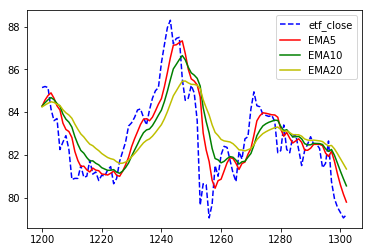

In [16]:
#圖形化顯示
#aetf_pd_50.set_index('etf_date') #set_index 後配合 loc select 出區段資料來看
etf_pd_50_part = etf_pd_50.loc[1200:]
etf_pd_50_part.etf_close.plot(x='row_idx', y='etf_close', style='b--', label="etf_close")
etf_pd_50_part.EMA5.plot(x='row_idx', y='EMA5', label="EMA5", style='r-')
etf_pd_50_part.EMA10.plot(x='row_idx', y='EMA10', label="EMA10", style='g-')
etf_pd_50_part.EMA20.plot(x='row_idx', y='EMA20', label="EMA20", style='y-')
plt.legend()
plt.show()

In [19]:
#計算各欄位與收盤價之相關性
corr_cols = ['EMA5','EMA10','EMA20','BIAS','K','D']
for col in corr_cols:
    print('corr between ', col , ' and etf_close: ', str(tetfp_dt2.corr(col, 'etf_close')))

corr between  EMA5  and etf_close:  0.9903396716685616
corr between  EMA10  and etf_close:  0.9811876234371903
corr between  EMA20  and etf_close:  0.964094890237929
corr between  BIAS  and etf_close:  0.10899567830506814
corr between  K  and etf_close:  0.03813736733655375
corr between  D  and etf_close:  0.044052741412852356


In [23]:
ll = [46.92, 47.31, 47.0, 46.79, 46.49, 46.66, 47.0, 46.96, 47.0, 47.0, 46.79, 46.49, 46.66]
print(ll[len(ll)-9:])
ll = [46.92, 47.31, 47.0, 46.79, 46.49, 46.66]
win_len=5
print(ll[1:])
print(ll[0: -1])
print(list(map(lambda x,y : x - y, ll[1:], ll[0: -1])))
for x in ll[win_len:]:
    print(x)
ema = sum(ll[:win_len])/len(ll[:win_len])
print(ema)
for price in ll[win_len:]:
    ema = (ema*(win_len-1)+price*2)/(win_len+1)
tup1, tup2 = (1,2)
print(tup1, ' ', tup2)
tup = (3,4)
print(tup[0], ' ', tup[1])
list(range(0,2))

[46.49, 46.66, 47.0, 46.96, 47.0, 47.0, 46.79, 46.49, 46.66]
[47.31, 47.0, 46.79, 46.49, 46.66]
[46.92, 47.31, 47.0, 46.79, 46.49]
[0.39000000000000057, -0.3100000000000023, -0.21000000000000085, -0.29999999999999716, 0.1699999999999946]
46.66
46.902
1   2
3   4


[0, 1]